## Sentiment Analysis

Objective: How well can we predict a restaurant’s Zomato score using the polarity of their reviews as input?

### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import nltk
import statistics
import random

#Preprocessing
from utils importpipeline
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()
from sentiment_analysis import sentiment_analysis_functions

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Sentiment Analysis with VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentiment Analysis with TextBlob
#%pip install textblob
from textblob import TextBlob

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msard\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Preprocessing

In [ ]:
# Importing the dataset, and preparing it for analysis
reviews = pd.read_csv('data_hyderabad/10k_reviews.csv')
reviews = sentiment_analysis_functions.prepare_dataset_sentiment(reviews)
reviews.sample(5)

,Review,Zomato Score
7251,Ordered a Vanilla Fudge cake for my wife's bda...,3.915000
1059,roti nd nan both u gave me without butter nd i...,3.250000
4535,biriyani rice was not boiled properly..it was ...,3.290000
9226,"We went there for dinner...\nThe place , the a...",3.410000
7992,sweet was not served with ordered veg executiv...,3.767677


In [8]:
# Creating the example class for sentiment analysis
class SA_Example():
    def __init__(self, example_row) -> None:
        self.index = example_row.index[0]
        self.score = example_row["Zomato Score"].values[0]
        self.raw_content = example_row["Review"].values[0]

In [9]:
# Store the result as an example object
reviews_row = reviews.loc[reviews["Review"] == reviews.Review.sample(1).values[0]]
reviews_example = SA_Example(reviews_row)

Since we are using VADER:
- Letter case should be preserved
- Stopwords should be preserved
- Punctuation should be preserved

In [ ]:
reviews["Preproc_Review"] =\
      reviews["Review"].map(lambda content :pipeline.main_pipeline(content,
                                                                        print_output=False,
                                                                        no_stopwords=False,
                                                                        lowercase=False,
                                                                        lemmatized=False,
                                                                        no_punctuation=False
                                                                        ))

In [13]:
sent_tokenizer = PunktSentenceTokenizer()
reviews_example.tokenized_sentences = sent_tokenizer.tokenize(reviews_example.raw_content)
reviews_example.tokenized_sentences

['Loved the food.',
 'Very cute ambience.',
 'Service was the downside, though.',
 'Despite the crowd being normal and not heavy, none of the waiters were in sight when we needed them.',
 'That being said, I recommend the wontons, the manchow soup and the chilly paneer.',
 'Fried rice was a little insipid but other than that, a definite recommendation.']

In [14]:
reviews["Preproc_Sentences"] =\
      reviews["Review"].map(lambda content : [pipeline_v1e.main_pipeline(sentence,
                                                                            print_output=False,
                                                                            no_stopwords=False,
                                                                            lowercase=False,
                                                                            lemmatized=False,
                                                                            no_punctuation=False
                                                                            ) for sentence in sent_tokenizer.tokenize(content)])

### VADER sentiment analyser

Testing with an example

In [22]:
vader = SentimentIntensityAnalyzer()

In [21]:
sent_compound_list = []

for sentence in reviews_example.tokenized_sentences:
    sent_polarity = vader.polarity_scores(sentence)
    sent_compound_list.append(sent_polarity["compound"])
    print("{} : \n {}".format(sentence, sent_polarity))

Loved the food. : 
 {'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'compound': 0.5994}
Very cute ambience. : 
 {'neg': 0.0, 'neu': 0.378, 'pos': 0.622, 'compound': 0.5095}
Service was the downside, though. : 
 {'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.25}
Despite the crowd being normal and not heavy, none of the waiters were in sight when we needed them. : 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
That being said, I recommend the wontons, the manchow soup and the chilly paneer. : 
 {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}
Fried rice was a little insipid but other than that, a definite recommendation. : 
 {'neg': 0.137, 'neu': 0.666, 'pos': 0.196, 'compound': 0.2014}


In [25]:
scratch_df = pd.DataFrame({"Sentences":[sentence for sentence in reviews_example.tokenized_sentences], "Compound_Score":sent_compound_list})
scratch_df.describe()

,Compound_Score
count,6.000000
mean,0.236917
std,0.321130
min,-0.250000
25%,0.050350
50%,0.281300
75%,0.472425
max,0.599400


In [27]:
test_review_polarity = vader.polarity_scores(reviews_example.raw_content)
print(test_review_polarity)
print(reviews_example.score)

{'neg': 0.056, 'neu': 0.795, 'pos': 0.149, 'compound': 0.6851}
3.06


Applying VADER

In [28]:
def vader_wrapper(user_review):    
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(vader.polarity_scores(sentence)["compound"])
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = vader.polarity_scores(user_review)["compound"]
    return polarity

In [31]:
reviews["content_polarity_vader"] = reviews["Preproc_Review"].map(lambda review: vader_wrapper(review))
reviews["mean_sentence_polarity_vader"] = reviews["Preproc_Sentences"].map(lambda review: vader_wrapper(review))
reviews.sample(5)

,Review,Zomato Score,Preproc_Sentences,Preproc_Review,content_polarity_vader,mean_sentence_polarity_vader
4078,The food and drinks are amazing here.The beer ...,3.610,[The food and drinks are amazing here.The beer...,The food and drinks are amazing here.The beer ...,0.9245,0.577767
1843,I had gone for lunch a few days back and no do...,3.800,[I had gone for lunch a few days back and no d...,I had gone for lunch a few days back and no do...,-0.2136,-0.248600
5001,"Cool Interior, Service was bit slow, Being a p...",3.610,"[Cool Interior, Service was bit slow, Being a ...","Cool Interior, Service was bit slow, Being a p...",0.8750,0.875000
4042,They serve very small portions.. not at all wo...,3.610,[They serve very small portions .. not at all ...,They serve very small portions .. not at all w...,0.8494,0.181375
4686,Heard so much about this restaurant and went t...,3.225,[Heard so much about this restaurant and went ...,Heard so much about this restaurant and went t...,0.6187,0.206233


Comparing Content Polarity with Mean Sentence Polarity

In [33]:
pearson_r, p_value = pearsonr(reviews["mean_sentence_polarity_vader"],reviews["content_polarity_vader"])
pearson_r

0.8198408093599588

### Using TextBlob

Testing

In [34]:
test_blob = TextBlob(reviews_example.raw_content)
test_blob.sentiment

Sentiment(polarity=0.0859375, subjectivity=0.653125)

In [35]:
def textblob_wrapper(user_review):   
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(TextBlob(sentence).sentiment.polarity)
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = TextBlob(user_review).sentiment.polarity
    return polarity

In [38]:
round(textblob_wrapper(reviews_example.tokenized_sentences), 5)

0.12847

Applying

In [39]:
reviews["content_polarity_textblob"] = reviews["Preproc_Review"].map(lambda review : textblob_wrapper(review))
reviews["mean_sentence_polarity_textblob"] = reviews["Preproc_Sentences"].map(lambda review : textblob_wrapper(review))

In [40]:
pearson_r, p_value = pearsonr(reviews["mean_sentence_polarity_textblob"],reviews["content_polarity_textblob"])
pearson_r

0.9547798375129646

### Comparing the SA results against the average zomato score of the restaurant

In [41]:
pearson_r, p_value = pearsonr(reviews["Zomato Score"],reviews["content_polarity_vader"])
pearson_r

0.33125399788032617

In [42]:
scaler = preprocessing.MinMaxScaler()
#The "reshape(-1,1)" is there to make sure that the column is fed as a 2D (4915 x 1) array
normalized_score = scaler.fit_transform(reviews["Zomato Score"].to_numpy().reshape(-1, 1))
normalized_polarity_vader = scaler.fit_transform(reviews["content_polarity_vader"].to_numpy().reshape(-1, 1))

#The "reshape(-1)" is there to flatten the 2D array into a 1D array
pearson_r, p_value = pearsonr(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1))
pearson_r

0.33125399788032656

In [43]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1))
print("RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

RMSE: 0.39; MAPE: 20528180076598.91


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_vader.reshape(-1)+1)

print("RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

RMSE: 0.39; MAPE: 0.238


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Summary

In [45]:
reviews["normalized_score"] = normalized_score.reshape(-1)
reviews["normalized_polarity_vader"] = normalized_polarity_vader.reshape(-1)
reviews.describe()

,Zomato Score,content_polarity_vader,mean_sentence_polarity_vader,content_polarity_textblob,mean_sentence_polarity_textblob,normalized_score,normalized_polarity_vader
count,9955.000000,9955.000000,9955.000000,9.955000e+03,9955.000000,9955.000000,9955.000000
mean,3.600263,0.475257,0.275961,2.492013e-01,0.226977,0.483977,0.736976
std,0.505936,0.585091,0.373486,3.644299e-01,0.336662,0.204007,0.293441
min,2.400000,-0.994200,-0.972100,-1.000000e+00,-1.000000,0.000000,0.000000
25%,3.230000,0.000000,0.000000,5.551115e-17,0.000000,0.334677,0.498621
50%,3.610000,0.765000,0.318200,2.750000e-01,0.233510,0.487903,0.882291
75%,3.845000,0.935900,0.503653,5.034524e-01,0.451181,0.582661,0.968002
max,4.880000,0.999700,0.995000,1.000000e+00,1.000000,1.000000,1.000000


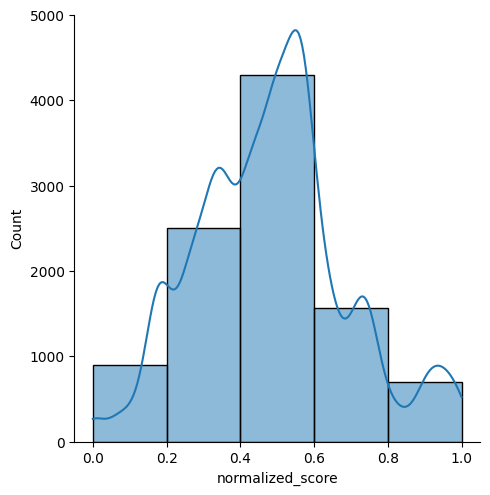

In [46]:
score_graph = sns.displot(reviews["normalized_score"], kde=True, bins=5)
plt.ylim(0, 5000)
plt.show()

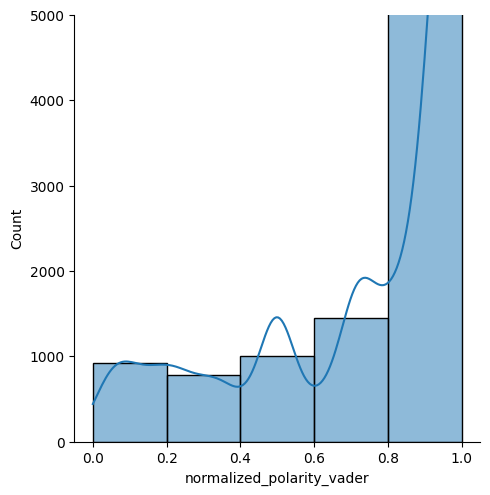

In [47]:
polarity_graph = sns.displot(reviews["normalized_polarity_vader"], kde=True, bins=5)
plt.ylim(0, 5000)
plt.show()

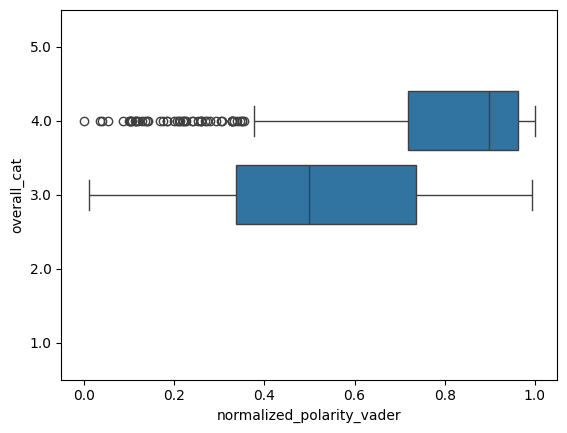

In [50]:
# Ensure the 'overall_cat' column is formatted correctly
reviews["overall_cat"] = reviews["Zomato Score"].apply(lambda score: f"{score:.1f}")

# Create the boxplot with the correct order
sns.boxplot(data=reviews, x="normalized_polarity_vader", y="overall_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

In [51]:
normalized_polarity_textblob = scaler.fit_transform(reviews["content_polarity_textblob"].to_numpy().reshape(-1, 1))
reviews["normalized_polarity_textblob"] = normalized_polarity_textblob.reshape(-1)
pearson_r, p_value = pearsonr(normalized_score.reshape(-1), normalized_polarity_textblob.reshape(-1))
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_textblob.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_textblob.reshape(-1)+1)

print("Pearson R: {}; RMSE: {}; MAPE: {}".format(round(pearson_r, 3), round(rmse, 3), round(mape, 3)))

Pearson R: 0.292; RMSE: 0.27; MAPE: 0.155


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


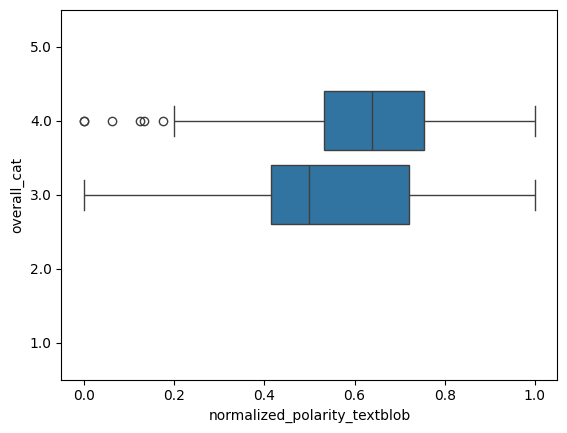

In [52]:
sns.boxplot(data=reviews, x="normalized_polarity_textblob", y="overall_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

### Comparing VADER and TextBlob

In [54]:
pearson_r, p_value = pearsonr(reviews["normalized_polarity_vader"],reviews["normalized_polarity_textblob"])
pearson_r

0.658923407493906

<Axes: xlabel='normalized_polarity_vader', ylabel='normalized_polarity_textblob'>

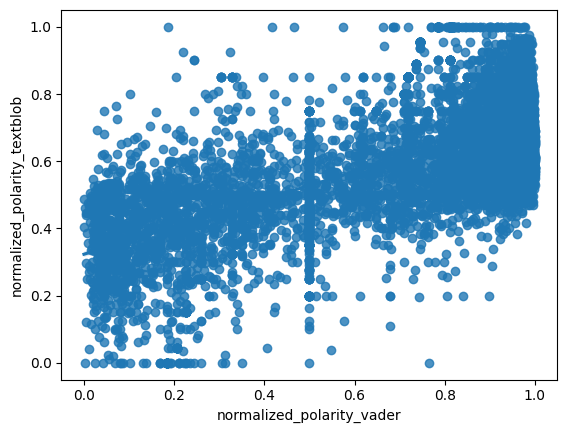

In [55]:
sns.regplot(data=reviews, x="normalized_polarity_vader", y="normalized_polarity_textblob")

In [56]:
reviews.describe()

,Zomato Score,content_polarity_vader,mean_sentence_polarity_vader,content_polarity_textblob,mean_sentence_polarity_textblob,normalized_score,normalized_polarity_vader,normalized_polarity_textblob
count,9955.000000,9955.000000,9955.000000,9.955000e+03,9955.000000,9955.000000,9955.000000,9955.000000
mean,3.600263,0.475257,0.275961,2.492013e-01,0.226977,0.483977,0.736976,0.624601
std,0.505936,0.585091,0.373486,3.644299e-01,0.336662,0.204007,0.293441,0.182215
min,2.400000,-0.994200,-0.972100,-1.000000e+00,-1.000000,0.000000,0.000000,0.000000
25%,3.230000,0.000000,0.000000,5.551115e-17,0.000000,0.334677,0.498621,0.500000
50%,3.610000,0.765000,0.318200,2.750000e-01,0.233510,0.487903,0.882291,0.637500
75%,3.845000,0.935900,0.503653,5.034524e-01,0.451181,0.582661,0.968002,0.751726
max,4.880000,0.999700,0.995000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
